# Delivery Hero dataset

[Blog](https://tech.deliveryhero.com/delivery-heros-double-feature-at-acm-recsys-2023/)

[Github repo](https://github.com/deliveryhero/dh-reco-dataset)


The dataset includes 3 zip archives, each one corresponding to a particular city. There are the following datasets in each zip file:
* products
* orders
* vendors  

Let's read and explore all the datasets

In [75]:
import os
import zipfile
import pandas as pd
from io import StringIO

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

In [ ]:
path = '/content/drive/MyDrive/0_Projects/food-delivery'
os.chdir(path)

# Download dataset
The three zip archives can be downloaded manually at this [link](https://drive.google.com/drive/folders/1dCUvFVmt9xNOGgadql_O16SwtGy6e_hE)

# EDA

In [ ]:
folder = 'delivery-hero-dataset'
os.listdir(folder)

['data_se.zip', 'data_tw.zip', 'data_sg.zip']

## Stockholm: data_se.zip

In [ ]:
fn = 'data_se.zip'
zip_file_path = os.path.join(folder, fn)
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract the list of filenames
    filenames = zip_ref.namelist()
df = pd.DataFrame(filenames)
df.shape

(10, 1)

In [ ]:
df

,0
0,data_se/
1,__MACOSX/._data_se
2,data_se/products_se.txt
3,__MACOSX/data_se/._products_se.txt
4,data_se/orders_se_train.txt
5,data_se/orders_se.txt
6,__MACOSX/data_se/._orders_se.txt
7,data_se/orders_se_test.txt
8,data_se/vendors_se.txt
9,__MACOSX/data_se/._vendors_se.txt


### prods_se: data_se/products_se.txt

In [ ]:
fn = 'data_se.zip'
zip_file_path = os.path.join(folder, fn)
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
  ds_name = 'data_se/products_se.txt'
  with zip_ref.open(ds_name) as file:
        file_content = file.read().decode('utf-8')
        prods_se = pd.read_csv(StringIO(file_content),
                               index_col=0)
prods_se.shape

(111046, 4)

In [ ]:
prods_se.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 111046 entries, 0 to 111045
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   vendor_id   111046 non-null  object 
 1   product_id  111046 non-null  object 
 2   name        111046 non-null  object 
 3   unit_price  111046 non-null  float64
dtypes: float64(1), object(3)
memory usage: 4.2+ MB


as we can see, there are no missing values in the dataset

In [ ]:
prods_se

,vendor_id,product_id,name,unit_price
0,e21306e2,055e72373069,Small,0.496
1,7b111c3f,ec33db14a2c5,Alcachofas Empinzadas,0.304
2,4dc46e0f,fa04d9e5b964,Coca-Cola 2L,0.240
3,14d2b0c7,9f502de9373e,"5 Lax, 5 Räkor, 5 Avokado",0.820
4,31113bdf,f917c5731301,Kyckling Szechuan Special,0.632
...,...,...,...,...
111041,4a793e0c,12835eb55943,Bruschetta Gratinata,0.380
111042,fd05d06e,1107981e7f19,Räksallad,0.380
111043,6e62a3c9,b64147e24130,Smokey BBQ Beef Double Meal,0.380
111044,7c2d1a3d,98e7715c659b,20st Chicken McNuggets® & Co,0.380


#### product price distribution

27% of products have prices equal to 0

In [ ]:
len(prods_se.query("unit_price==0"))/len(prods_se)

0.2708697296615817

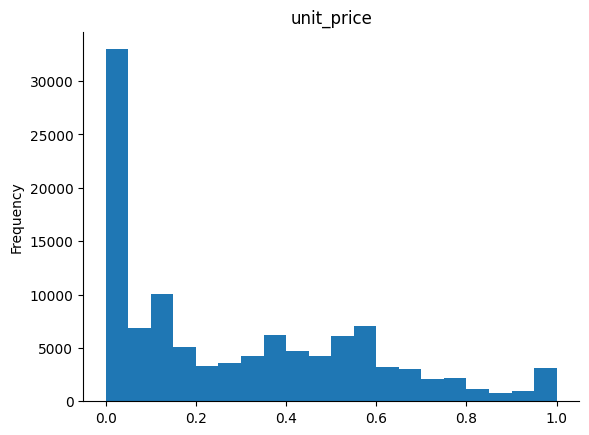

In [ ]:
from matplotlib import pyplot as plt
prods_se['unit_price'].plot(kind='hist', bins=20, title='unit_price')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
prods_se.query("unit_price == 0")

,vendor_id,product_id,name,unit_price
24590,7fb61536,a898fb22b3c2,Jag vill inte ha Supreme vitlöksbröd,0.0
24591,4dc46e0f,882c799e0d23,Köttfärs,0.0
24592,d7650033,3a9093be7666,Isbergssallad,0.0
24593,d7650033,96e5326ace5b,Pommes,0.0
24594,23502dc9,1273d3c6c10d,Lime,0.0
...,...,...,...,...
54664,be5e75da,95ec8a580f90,Ost,0.0
54665,788e4397,d8a238de3036,Fläskfilé,0.0
54666,acb981ef,44699b2408c4,Räkor,0.0
54667,f2f14509,3dd0f1eaa3a4,Glasnudlar,0.0


over 30 K products out of 111 K total have prices equal to 0. It is impossible to explain without context (could be replacement of missing values, etc.)

let's filter out products with prices equal to 0 and analyze price distribution of remaining products (prices are normalized on the scale from 0 - 1):

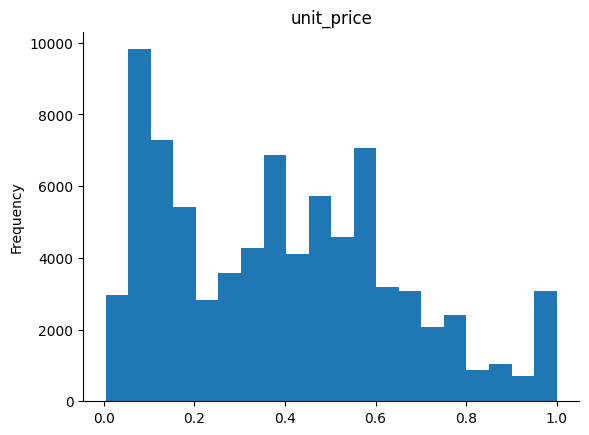

In [ ]:
from matplotlib import pyplot as plt
prods_se.query("unit_price!=0")['unit_price'].plot(kind='hist', bins=20, title='unit_price')
plt.gca().spines[['top', 'right',]].set_visible(False)

we can notice 3 groups of products:
* with prices <= 0.2
* with prices 0.4 - 0.6
* with prices near 1.0

### vendors_se

In [ ]:
fn = 'data_se.zip'
zip_file_path = os.path.join(folder, fn)
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
  ds_name = 'data_se/vendors_se.txt'
  with zip_ref.open(ds_name) as file:
        file_content = file.read().decode('utf-8')
        vendors_se = pd.read_csv(StringIO(file_content),
                               index_col=0)
vendors_se.shape

(1148, 4)

In [ ]:
vendors_se

,vendor_id,chain_id,geohash,primary_cuisine
0,a5028ec5,NaN,u6sc9,thai
1,fed855cd,NaN,u6sc7,thai
2,5f4ad3ab,NaN,u6sc8,sushi
3,83b6b60e,NaN,u6sce,asiatiskt
4,8978d654,NaN,u6scd,asiatiskt
...,...,...,...,...
2331,5e4c2953,d9a864aa,u6sc8,unknown
2334,964cf7a5,NaN,u6scd,spanskt
2335,181dfe2a,NaN,u6sc7,italienskt
2336,7b111c3f,NaN,u6scd,spanskt


### orders_se: data_se/orders_se.txt

In [ ]:
fn = 'data_se.zip'
zip_file_path = os.path.join(folder, fn)
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
  ds_name = 'data_se/orders_se.txt'
  with zip_ref.open(ds_name) as file:
        file_content = file.read().decode('utf-8')
        orders_se = pd.read_csv(StringIO(file_content),
                               index_col=0)
orders_se.shape

(756738, 8)

In [ ]:
orders_se

,customer_id,geohash,order_id,vendor_id,product_id,day_of_week,order_time,order_day
0,90a4e98622,u6sc4,0,e1f3e4a4,9971ae2cd1ba,3,16:00:16,11 days
1,90a4e98622,u6sc4,0,e1f3e4a4,00734c4b351f,3,16:00:16,11 days
2,90a4e98622,u6sc4,1,5d1b1300,9a2b00f39640,1,16:34:04,51 days
3,90a4e98622,u6sc4,2,5d1b1300,9a2b00f39640,6,14:39:12,84 days
4,90a4e98622,u6sc4,3,5d1b1300,9a2b00f39640,3,16:23:14,53 days
...,...,...,...,...,...,...,...,...
756733,b8aba8a2e4,u6sc4,399996,046516e5,2cfde40e0a67,4,16:45:59,89 days
756734,82b90e35bb,u6sc6,399997,30ab5c5b,8fccd71c6af1,2,18:36:34,73 days
756735,82b90e35bb,u6sc6,399997,30ab5c5b,f9c2aa33151d,2,18:36:34,73 days
756736,82b90e35bb,u6sc6,399998,606058dc,13ef5c0306dc,3,17:27:48,4 days


#### orders age


We add numeric order_age column by extracting numerical values from 'order_day' strings. We sort the dataset by the new 'order_age' column.
After grouping the dataset by the new column and counting the number of orders, we can see that orders have cycles, which must be weekly ones.

We confirm existance of weekly ccycles by applying seasonal decompose method with period = 7


In [ ]:
orders_se['order_age'] = orders_se['order_day'].str.extract("([0-9]+)")
orders_se.sort_values('order_age',inplace=True)

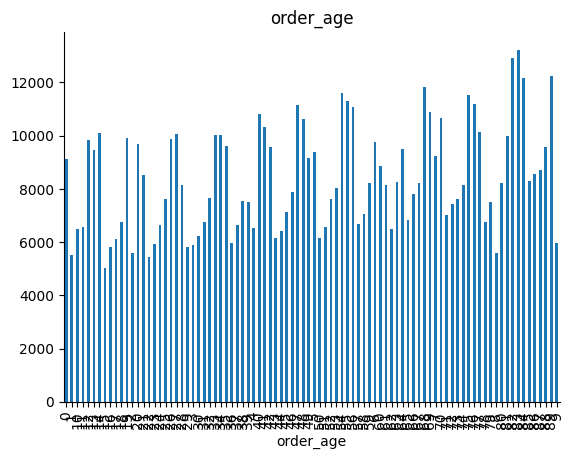

In [ ]:
orders_se['order_age'].groupby(orders_se['order_age']).count().plot(kind='bar',
                                                                     title='order_age')
plt.gca().spines[['top', 'right',]].set_visible(False)

#### orders weekly seasonality

In [77]:
# Decompose the time series
data = orders_se['order_age'].groupby(orders_se['order_age']).count()
decomposition = seasonal_decompose(data, model='additive', period=7)

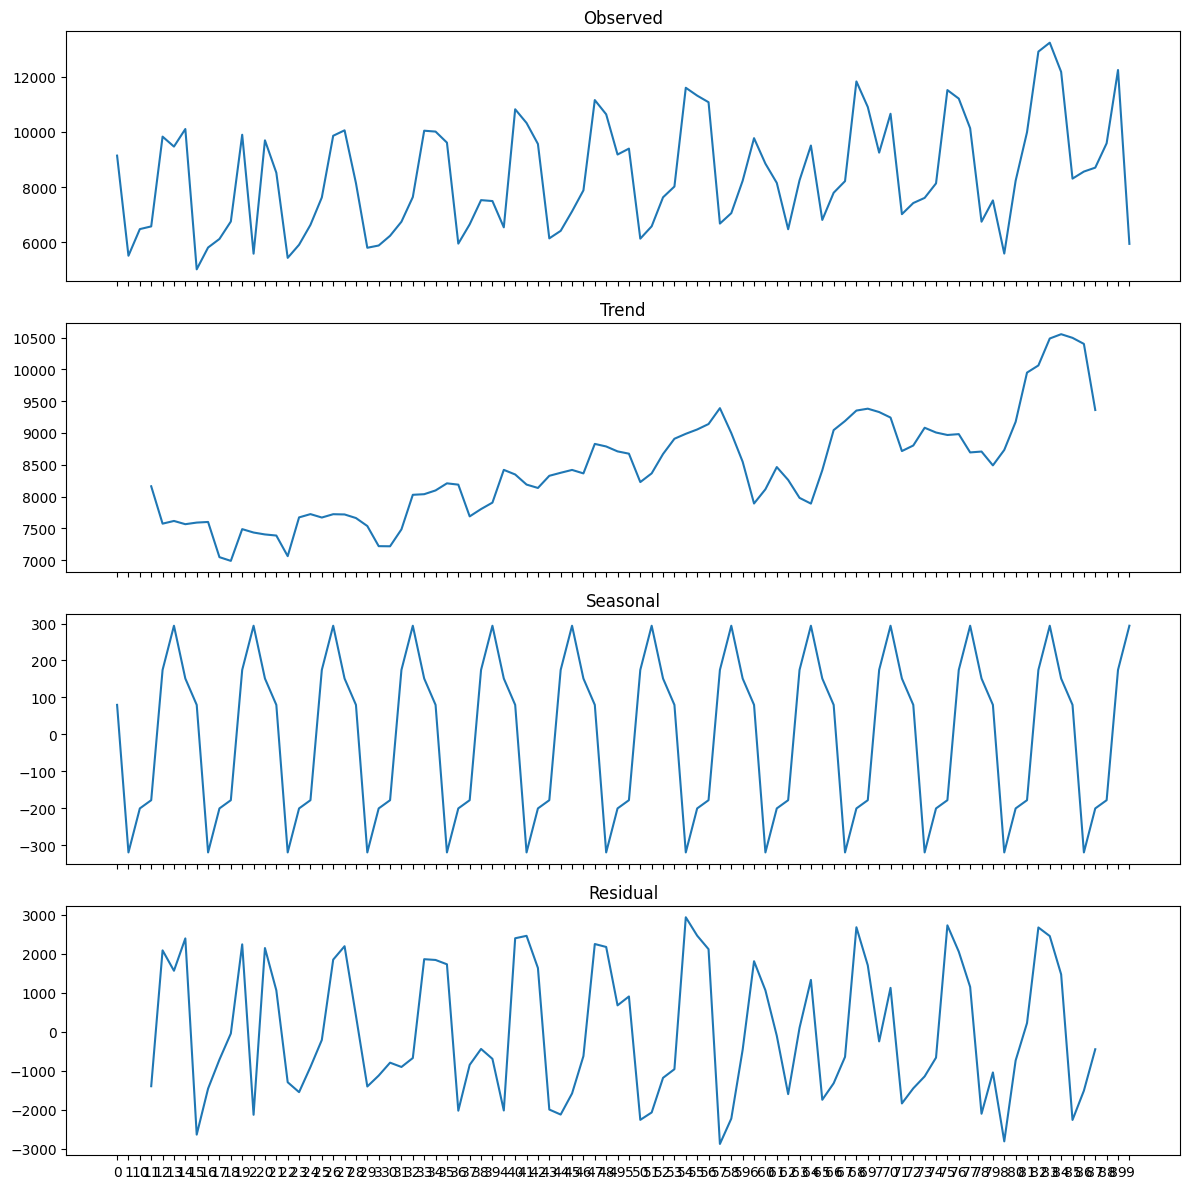

In [74]:
# Plot the decomposition
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 12), sharex=True)
ax1.plot(decomposition.observed)
ax1.set_title('Observed')
ax2.plot(decomposition.trend)
ax2.set_title('Trend')
ax3.plot(decomposition.seasonal)
ax3.set_title('Seasonal')
ax4.plot(decomposition.resid)
ax4.set_title('Residual')
plt.tight_layout()
plt.show()

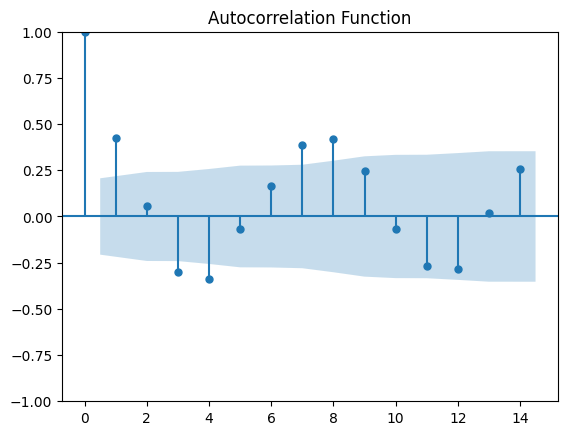

In [76]:
# Plot the ACF
plot_acf(data, lags=14)
plt.title('Autocorrelation Function')
plt.show()

#### orders trend
7-day rolling mean eliminates weekly seasonality and shows if there is a trend in order quantity per day.

the chart below shows there is a growing trend in the number of orders per day

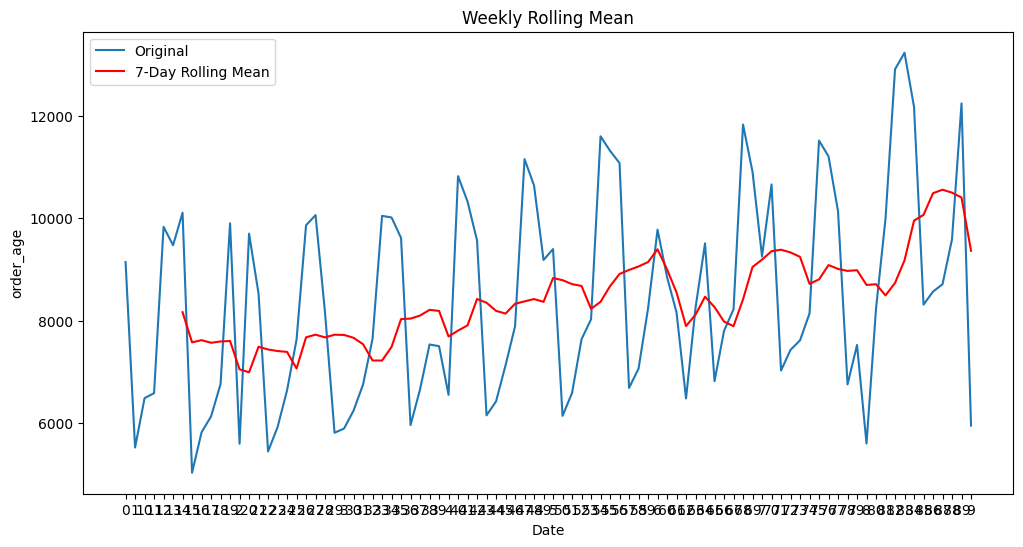

In [78]:
data_df = pd.DataFrame(data)
data_df['weekly_mean'] = data_df['order_age'].rolling(window=7).mean()

# Plot the rolling mean
plt.figure(figsize=(12, 6))
plt.plot(data_df['order_age'], label='Original')
plt.plot(data_df['weekly_mean'], label='7-Day Rolling Mean', color='red')
plt.title('Weekly Rolling Mean')
plt.xlabel('Date')
plt.ylabel('order_age')
plt.legend()
plt.show()

### train and test splits
simple splits of orders_se file, no additinal features

In [ ]:

fn = 'data_se.zip'
zip_file_path = os.path.join(folder, fn)
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
  ds_name = 'data_se/orders_se_train.txt'
  with zip_ref.open(ds_name) as file:
        file_content = file.read().decode('utf-8')
        orders_train_se = pd.read_csv(StringIO(file_content),
                               index_col=0)
orders_train_se.shape

(617196, 8)

In [ ]:
orders_train_se

,customer_id,geohash,order_id,vendor_id,product_id,day_of_week,order_time,order_day
0,90a4e98622,u6sc4,0,e1f3e4a4,9971ae2cd1ba,3,16:00:16,11 days
1,90a4e98622,u6sc4,0,e1f3e4a4,00734c4b351f,3,16:00:16,11 days
2,90a4e98622,u6sc4,1,5d1b1300,9a2b00f39640,1,16:34:04,51 days
4,90a4e98622,u6sc4,3,5d1b1300,9a2b00f39640,3,16:23:14,53 days
5,90a4e98622,u6sc4,4,4790e97d,f6b685cff997,2,15:34:13,66 days
...,...,...,...,...,...,...,...,...
756729,b8aba8a2e4,u6sc4,399994,4ae049da,4a2bcba389e3,4,13:12:33,61 days
756734,82b90e35bb,u6sc6,399997,30ab5c5b,8fccd71c6af1,2,18:36:34,73 days
756735,82b90e35bb,u6sc6,399997,30ab5c5b,f9c2aa33151d,2,18:36:34,73 days
756736,82b90e35bb,u6sc6,399998,606058dc,13ef5c0306dc,3,17:27:48,4 days


In [ ]:
fn = 'data_se.zip'
zip_file_path = os.path.join(folder, fn)
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
  ds_name = 'data_se/orders_se_test.txt'
  with zip_ref.open(ds_name) as file:
        file_content = file.read().decode('utf-8')
        orders_test_se = pd.read_csv(StringIO(file_content),
                               index_col=0)
orders_test_se.shape

(139542, 8)

In [ ]:
assert orders_test_se.shape[0] == orders_se.shape[0] - orders_train_se.shape[0]

## Singapore: data_sg.zip

In [ ]:
fn = 'data_sg.zip'
zip_file_path = os.path.join(folder, fn)
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract the list of filenames
    filenames = zip_ref.namelist()
df = pd.DataFrame(filenames)
df.shape

(10, 1)

In [ ]:
df

,0
0,data_sg/
1,__MACOSX/._data_sg
2,data_sg/orders_sg_train.txt
3,data_sg/products_sg.txt
4,__MACOSX/data_sg/._products_sg.txt
5,data_sg/orders_sg_test.txt
6,data_sg/orders_sg.txt
7,__MACOSX/data_sg/._orders_sg.txt
8,data_sg/vendors_sg.txt
9,__MACOSX/data_sg/._vendors_sg.txt


### prods_sg

In [ ]:
fn = 'data_sg.zip'
zip_file_path = os.path.join(folder, fn)
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
  ds_name = 'data_sg/products_sg.txt'
  with zip_ref.open(ds_name) as file:
        file_content = file.read().decode('utf-8')
        prods_sg = pd.read_csv(StringIO(file_content),
                               index_col=0)
prods_sg.shape

(1066840, 4)

In [ ]:
prods_sg

,vendor_id,product_id,name,unit_price
0,15bbf316,59099e089514,Meat & Seafood Combo 海鲜套餐,0.0036
1,e7b24dc0,52e1017fdbd9,Sausage Egg McMuffin® Meal,0.0024
2,e7b24dc0,fcb7110cd932,Scrambled Egg Burger w Chicken Meal,0.0024
3,7112a20b,d3e7708c2bc9,Maguro Sushi,0.0012
4,6137ef21,bf0d5ac0e03c,Family Meal - Prosp Chic TwLEVMx2 + ChBurgerHM,0.0100
...,...,...,...,...
1066835,3a3422b7,74792a33ac62,西兰花 Broccoli\t,0.0012
1066836,1ee69614,c782aedb62ae,Gula Melaka Sago 椰糖西米露,0.0012
1066837,67499b6a,59537c172b6a,Double Egg Prata,0.0012
1066838,f444f459,c999a7a4b2f5,Sprite,0.0012


#### product price distribution

as in Stockholm, over 27% of all products have prices equal to 0. This phenomena can't be explained without a context

In [ ]:
len(prods_sg.query("unit_price==0"))/len(prods_sg)

0.27608826065764314

unit_price normalization is probably bugged: all prices are heavily skewed towards 0.0

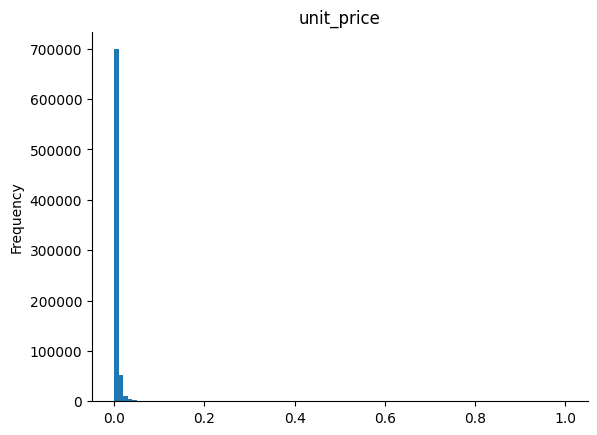

In [ ]:
from matplotlib import pyplot as plt
prods_sg.query("unit_price!=0")['unit_price'].plot(kind='hist', bins=100, title='unit_price')
plt.gca().spines[['top', 'right',]].set_visible(False)

### vendors_sg: data_sg/vendors_sg.txt

In [ ]:
fn = 'data_sg.zip'
zip_file_path = os.path.join(folder, fn)
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
  ds_name = 'data_sg/vendors_sg.txt'
  with zip_ref.open(ds_name) as file:
        file_content = file.read().decode('utf-8')
        vendors_sg = pd.read_csv(StringIO(file_content),
                               index_col=0)
vendors_sg.shape

(7411, 4)

In [ ]:
vendors_sg

,vendor_id,chain_id,geohash,primary_cuisine
0,b160c319,d2786168,w21z6,mexican
1,9c8f010e,d2786168,w21ze,mexican
4,03eb25e1,5055ab25,w21ze,bak kut teh
5,3613129a,8984acb6,w23b1,italian
7,0946c9e5,1e3a2913,w21z4,bak kut teh
...,...,...,...,...
17798,2d0b2dfb,1a3564c8,w21zt,mala xiang guo
17799,15bbf316,434020fb,w21zs,mala xiang guo
17801,a1f11221,b5431702,w21zu,mala xiang guo
17803,6268886c,0f494195,w21z8,mala xiang guo


### orders_sg: data_sg/orders_sg.txt

In [ ]:
fn = 'data_sg.zip'
zip_file_path = os.path.join(folder, fn)
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
  ds_name = 'data_sg/orders_sg.txt'
  with zip_ref.open(ds_name) as file:
        file_content = file.read().decode('utf-8')
        orders_sg = pd.read_csv(StringIO(file_content),
                               index_col=0)
orders_sg.shape

(4023005, 8)

#### orders age

We add numeric order_age column by extracting numerical values from 'order_day' strings. We sort the dataset by the new 'order_age' column.  
After grouping the dataset by the new column and counting the number of orders, we can see that orders have cycles, which must be weekly ones.  

We confirm existance of weekly ccycles by applying seasonal decompose method with period = 7

In [ ]:
orders_sg['order_age'] = orders_sg['order_day'].str.extract("([0-9]+)")
orders_sg.sort_values('order_age',inplace=True)

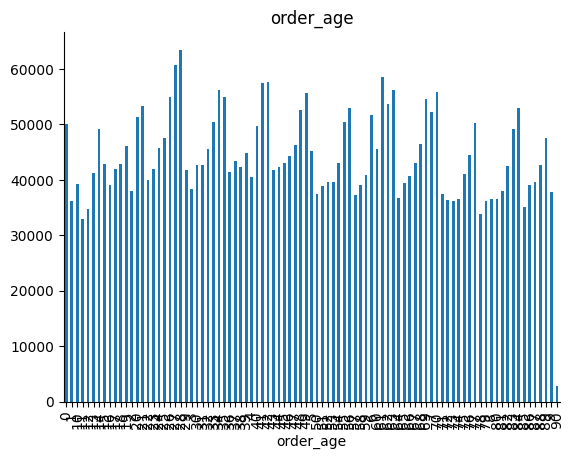

In [ ]:
orders_sg['order_age'].groupby(orders_sg['order_age']).count().plot(kind='bar',
                                                                     title='order_age')
plt.gca().spines[['top', 'right',]].set_visible(False)

#### orders weekly seasonality

In [ ]:
# Decompose the time series
data = orders_sg['order_age'].groupby(orders_sg['order_age']).count()
decomposition = seasonal_decompose(data, model='additive', period=7)

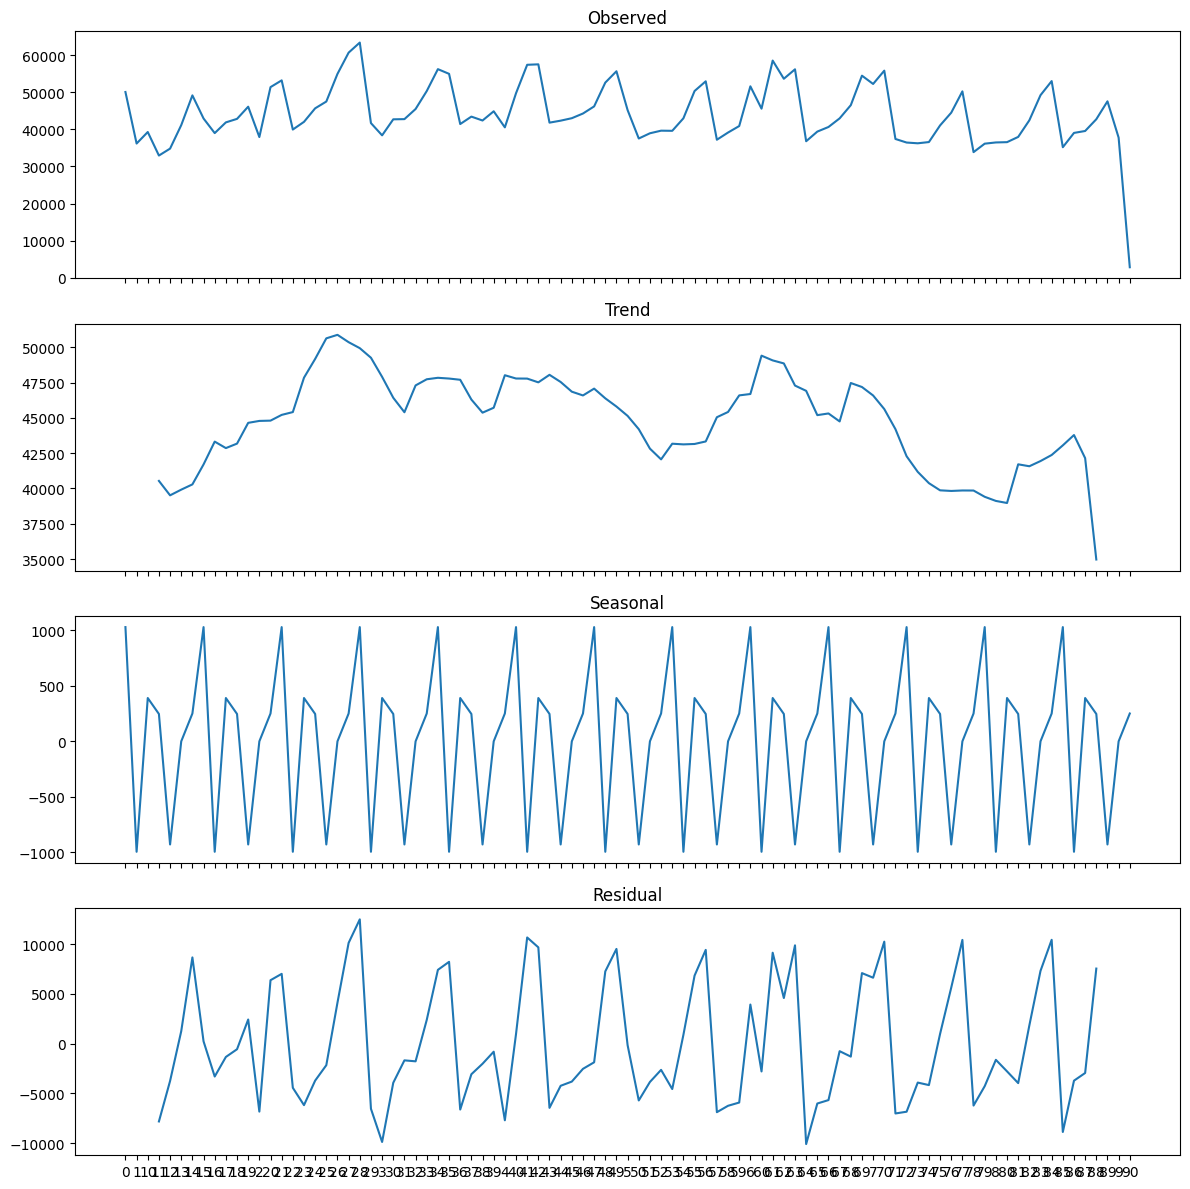

In [ ]:
# Plot the decomposition
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 12), sharex=True)
ax1.plot(decomposition.observed)
ax1.set_title('Observed')
ax2.plot(decomposition.trend)
ax2.set_title('Trend')
ax3.plot(decomposition.seasonal)
ax3.set_title('Seasonal')
ax4.plot(decomposition.resid)
ax4.set_title('Residual')
plt.tight_layout()
plt.show()

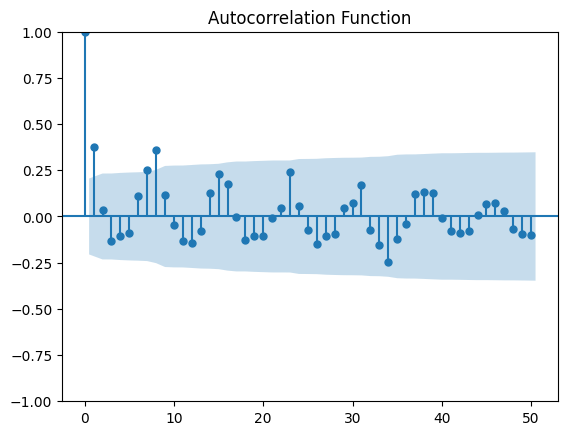

In [ ]:
# Plot the ACF
plot_acf(data, lags=50)
plt.title('Autocorrelation Function')
plt.show()

#### orders trend
7-day rolling mean eliminates weekly seasonality and shows if there is a trend in order quantity per day.

the chart below shows absence of a definitive trend

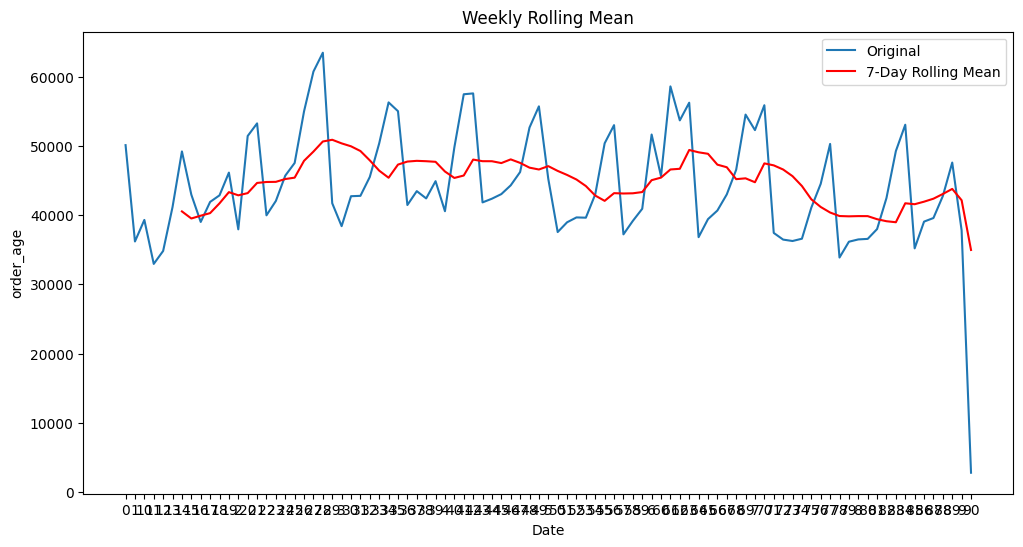

In [ ]:
data_df = pd.DataFrame(data)
data_df['weekly_mean'] = data_df['order_age'].rolling(window=7).mean()

# Plot the rolling mean
plt.figure(figsize=(12, 6))
plt.plot(data_df['order_age'], label='Original')
plt.plot(data_df['weekly_mean'], label='7-Day Rolling Mean', color='red')
plt.title('Weekly Rolling Mean')
plt.xlabel('Date')
plt.ylabel('order_age')
plt.legend()
plt.show()


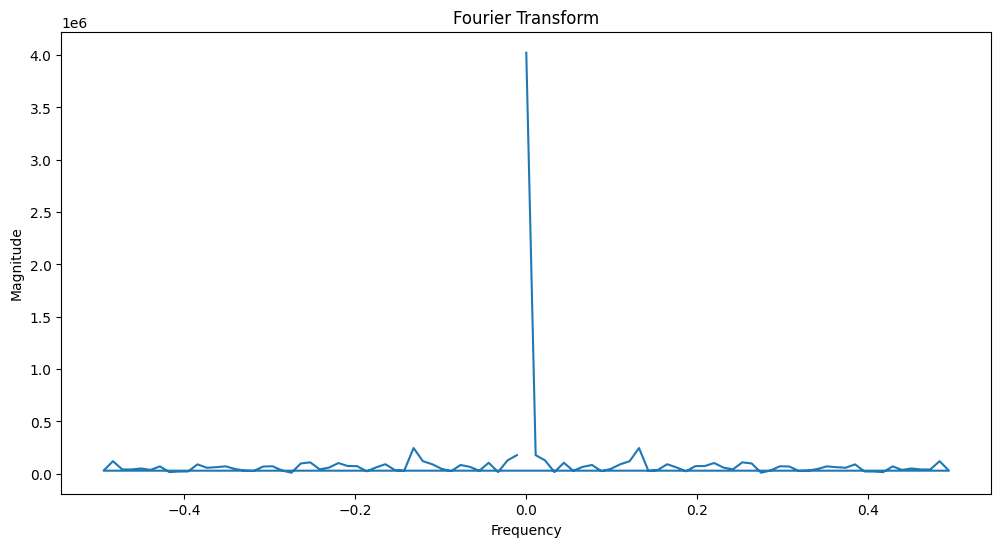

In [ ]:
from scipy.fftpack import fft
import numpy as np

# Apply Fourier Transform
fft_result = fft(data_df['order_age'].dropna())
frequencies = np.fft.fftfreq(len(fft_result))

# Plot the magnitude of frequencies
plt.figure(figsize=(12, 6))
plt.plot(frequencies, np.abs(fft_result))
plt.title('Fourier Transform')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.show()


## Taiwan: data_tw.zip

In [ ]:
fn = 'data_tw.zip'
zip_file_path = os.path.join(folder, fn)
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract the list of filenames
    filenames = zip_ref.namelist()
df = pd.DataFrame(filenames)
df.shape

(10, 1)

In [ ]:
df

,0
0,data_tw/
1,__MACOSX/._data_tw
2,data_tw/products_tw.txt
3,__MACOSX/data_tw/._products_tw.txt
4,data_tw/orders_tw_train.txt
5,data_tw/vendors_tw.txt
6,__MACOSX/data_tw/._vendors_tw.txt
7,data_tw/orders_tw_test.txt
8,data_tw/orders_tw.txt
9,__MACOSX/data_tw/._orders_tw.txt


### prods_tw

In [ ]:
fn = 'data_tw.zip'
zip_file_path = os.path.join(folder, fn)
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
  ds_name = 'data_tw/products_tw.txt'
  with zip_ref.open(ds_name) as file:
        file_content = file.read().decode('utf-8')
        prods_tw = pd.read_csv(StringIO(file_content),
                               index_col=0)
prods_tw.shape

(810536, 4)

#### product price distribution

prices of slightly over a quarter of all products are equal to 0

In [ ]:
len(prods_tw.query("unit_price==0"))/len(prods_tw)

0.2671590157624091

it seems that price normalization in Taiwan was contains an error: all prices are concentrated near 1.0

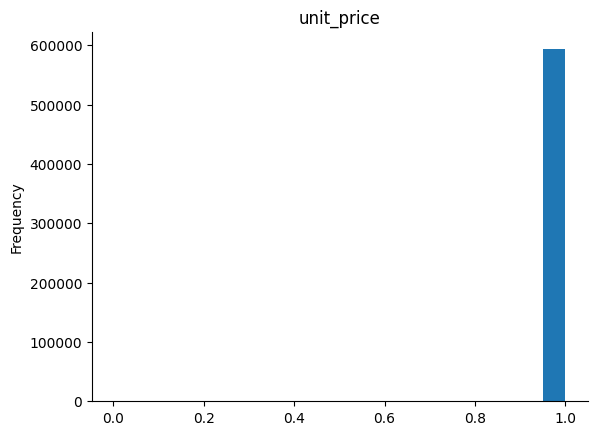

In [ ]:
prods_tw.query("unit_price!=0")['unit_price'].plot(kind='hist', bins=20, title='unit_price')
plt.gca().spines[['top', 'right',]].set_visible(False)

### vendors_tw

In [ ]:
fn = 'data_tw.zip'
zip_file_path = os.path.join(folder, fn)
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
  ds_name = f'data_tw/vendors_tw.txt'
  with zip_ref.open(ds_name) as file:
        file_content = file.read().decode('utf-8')
        vendors_tw = pd.read_csv(StringIO(file_content),
                               index_col=0)
vendors_tw.shape

(9506, 4)

### orders_tw

In [ ]:
fn = 'data_tw.zip'
zip_file_path = os.path.join(folder, fn)
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
  ds_name = f'data_tw/orders_tw.txt'
  with zip_ref.open(ds_name) as file:
        file_content = file.read().decode('utf-8')
        orders_tw = pd.read_csv(StringIO(file_content),
                               index_col=0)
orders_tw.shape

(4581346, 8)

#### orders_age


We add numeric order_age column by extracting numerical values from 'order_day' strings. We sort the dataset by the new 'order_age' column.
After grouping the dataset by the new column and counting the number of orders, we can see that orders have cycles, which must be weekly ones.

We confirm existance of weekly ccycles by applying seasonal decompose method with period = 7


In [ ]:
orders_tw['order_age'] = orders_tw['order_day'].str.extract("([0-9]+)")
orders_tw.sort_values('order_age',inplace=True)

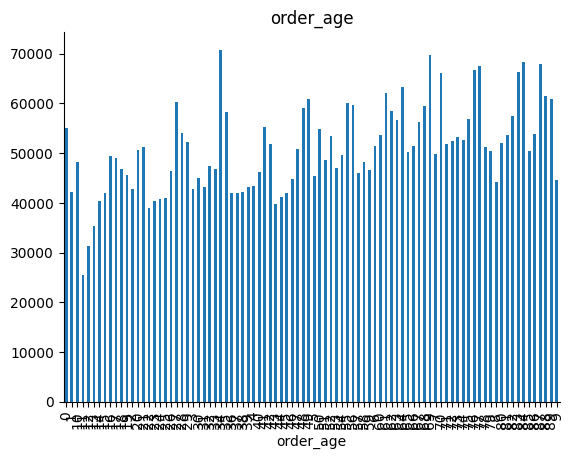

In [ ]:
orders_tw['order_age'].groupby(orders_tw['order_age']).count().plot(kind='bar',
                                                                     title='order_age')
plt.gca().spines[['top', 'right',]].set_visible(False)

#### orders weekly seasonality

In [ ]:
# Decompose the time series
data = orders_tw['order_age'].groupby(orders_tw['order_age']).count()
decomposition = seasonal_decompose(data, model='additive', period=7)

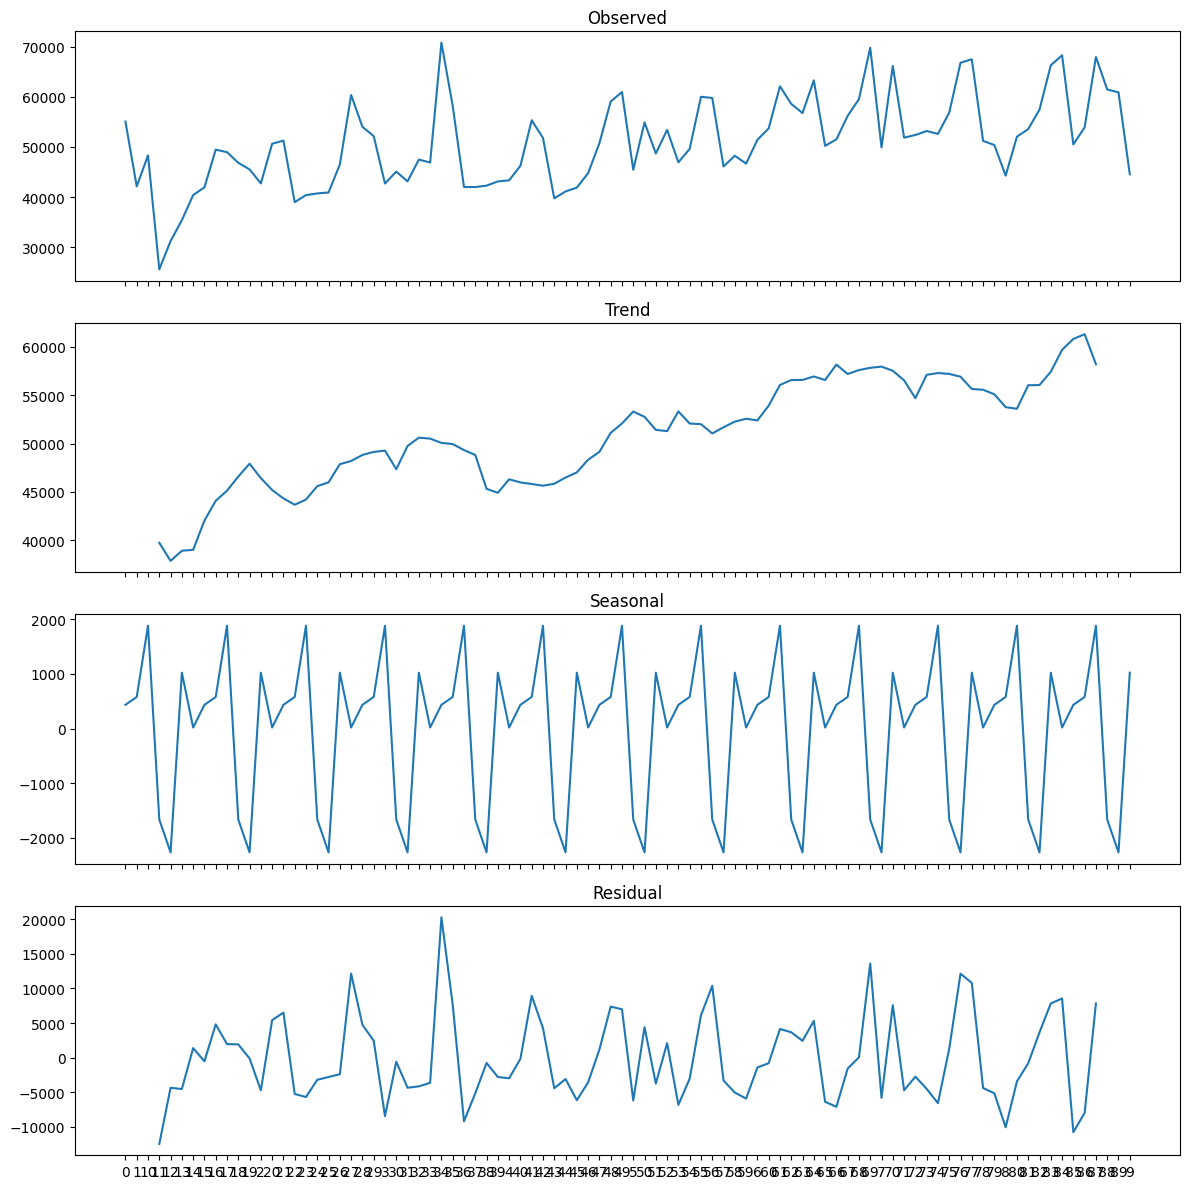

In [ ]:
# Plot the decomposition
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 12), sharex=True)
ax1.plot(decomposition.observed)
ax1.set_title('Observed')
ax2.plot(decomposition.trend)
ax2.set_title('Trend')
ax3.plot(decomposition.seasonal)
ax3.set_title('Seasonal')
ax4.plot(decomposition.resid)
ax4.set_title('Residual')
plt.tight_layout()
plt.show()

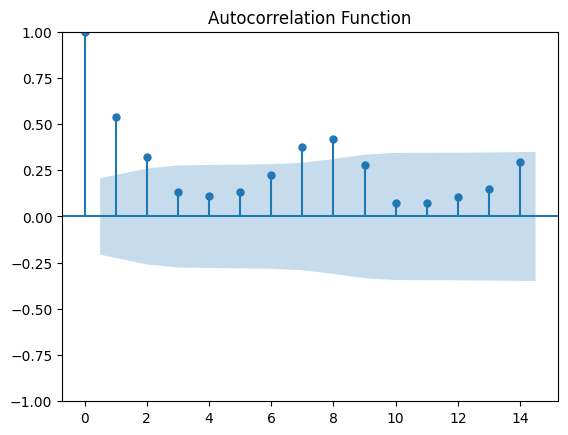

In [ ]:
# Plot the ACF
plot_acf(data, lags=14)
plt.title('Autocorrelation Function')
data+_plt.show()

#### orders trend
7-day rolling mean eliminates weekly seasonality and shows if there is a trend in order quantity per day.

the chart below shows there is a growing trend in the number of orders per day

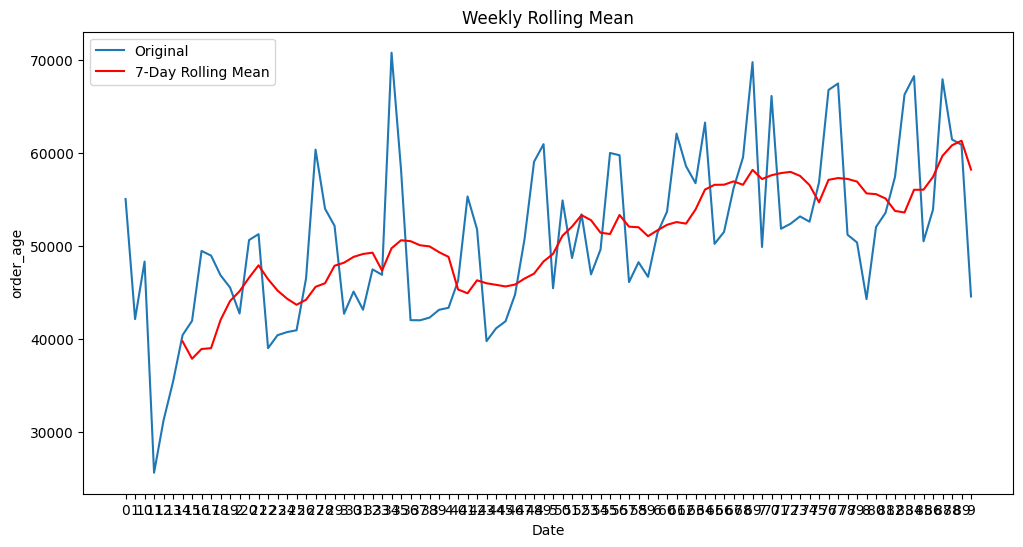

In [ ]:
data_df = pd.DataFrame(data)
data_df['weekly_mean'] = data_df['order_age'].rolling(window=7).mean()

# Plot the rolling mean
plt.figure(figsize=(12, 6))
plt.plot(data_df['order_age'], label='Original')
plt.plot(data_df['weekly_mean'], label='7-Day Rolling Mean', color='red')
plt.title('Weekly Rolling Mean')
plt.xlabel('Date')
plt.ylabel('order_age')
plt.legend()
plt.show()

## supply

### number of vendors by city

In [ ]:
se_num_vendors = prods_se.vendor_id.nunique()
sg_num_vendors = prods_sg.vendor_id.nunique()
tw_num_vendors = prods_tw.vendor_id.nunique()
print(f'Number of vendors in SE: {se_num_vendors}')
print(f'Number of vendors in SG: {sg_num_vendors}')
print(f'Number of vendors in TW: {tw_num_vendors}')

Number of vendors in SE: 1148
Number of vendors in SG: 7411
Number of vendors in TW: 9506


the number of vendors is the highest in Taiwan followed by Singapore. Stockholm has by far the lowest number of vendors.  

These numbers reflect the population numbers in the three areas:  
* Taiwan: 24 mil
* Singapore: 6 mil
* Stockhom: 1.7 mil

They can also reflect penetration of the Delivery Hero app in the respective areas, market competition or propensity of the population to order delivered food.  

For example, in Singapore there are 7411 vendors per 6 mil people, which renders 1.2 vendors per 1000 people; in Stickholm this coefficient is only 0.6 while in Taiwan it's even lower: 0.4

### number of products by city

In [ ]:
se_num_products = prods_se.product_id.nunique()
sg_num_products = prods_sg.product_id.nunique()
tw_num_products = prods_tw.product_id.nunique()
print(f'Number of products in SE: {se_num_products}')
print(f'Number of products in SG: {sg_num_products}')
print(f'Number of products in TW: {tw_num_products}')

Number of products in SE: 111046
Number of products in SG: 1066823
Number of products in TW: 810535


### primary cuisine distribution by area

In [ ]:
vendors_se.primary_cuisine.value_counts().head(15)

primary_cuisine
pizza           196
asiatiskt       106
burgare         103
indiskt          90
kafé             83
sushi            71
italienskt       66
thai             48
mellanöstern     38
svenskt          36
japanskt         32
mexikanskt       30
smörgåsar        24
amerikanskt      21
gatukök          20
Name: count, dtype: int64

In [ ]:
vendors_sg.primary_cuisine.value_counts().head(15)

primary_cuisine
chinese        770
noodles        398
bubble tea     371
indian         365
western        337
dessert        335
japanese       324
coffee         324
pizza          257
rice dishes    238
singaporean    228
chicken        189
thai           184
sandwiches     175
cakes          172
Name: count, dtype: int64

In [ ]:
vendors_tw.primary_cuisine.value_counts().head(15)

primary_cuisine
台式     3324
歐美     1358
飲料     1227
小吃     1180
日式      810
甜點      626
中式      235
東南亞     177
健康餐     177
韓式      130
素食      116
港式      106
異國       40
Name: count, dtype: int64

In [ ]:
台式: Taiwanese - 3324
歐美: Western - 1358
飲料: Beverages - 1227
小吃: Snacks - 1180
日式: Japanese - 810
甜點: Desserts - 626
中式: Chinese - 235
東南亞: Southeast Asian - 177
健康餐: Healthy - 177
韓式: Korean - 130
素食: Vegetarian - 116
港式: Hong Kong - 106
異國: Exotic/International - 40

# SE: Stockholm

# orders

In [ ]:
orders_se.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 756738 entries, 0 to 756737
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   customer_id  756738 non-null  object
 1   geohash      756738 non-null  object
 2   order_id     756738 non-null  int64 
 3   vendor_id    756738 non-null  object
 4   product_id   756738 non-null  object
 5   day_of_week  756738 non-null  int64 
 6   order_time   756738 non-null  object
 7   order_day    756738 non-null  object
dtypes: int64(2), object(6)
memory usage: 52.0+ MB


## products - SE

### prod_freq_df: analysis of product_id frequencies

The chart is a histogram showing the frequency distribution of the product_id variable. Here are the key observations:

The x-axis represents the product_id values.
The y-axis represents the frequency, i.e., the number of times each product_id occurs.
The majority of the product_id values are concentrated at the lower end of the range (close to 0), indicating a high frequency of lower product_id values.
There is a sharp drop-off in frequency as the product_id values increase, with very few occurrences beyond product_id value of 200.
The chart displays a highly skewed distribution with most of the data concentrated in the lower range of product_id values.

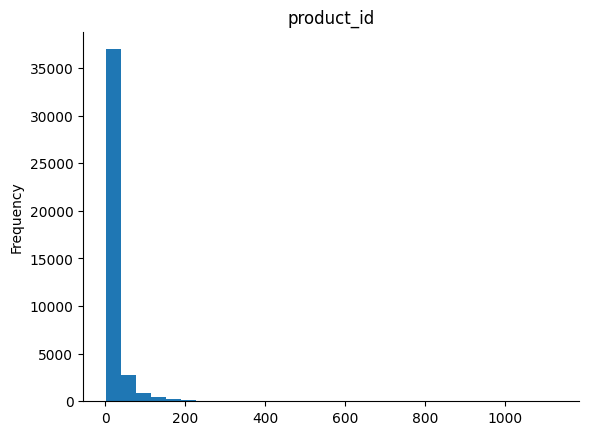

In [ ]:
orders_se['product_id'].value_counts().plot(kind='hist', bins=30, title='product_id')
plt.gca().spines[['top', 'right',]].set_visible(False)

let's filter out all items with freq<10

In [ ]:
prod_freq_df = orders_se['product_id'].value_counts().reset_index()
prod_freq_df.columns = ['product_id', 'freq']
prod_freq_df=prod_freq_df.sort_values('freq',
                         ascending=False,
                         ignore_index=True).query("freq>=10")
prod_freq_df.shape

(16130, 2)

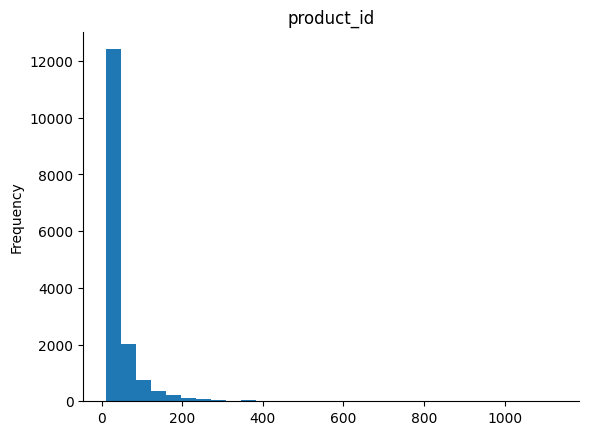

In [ ]:
prod_freq_df['freq'].plot(kind='hist', bins=30, title='product_id')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
prod_freq_df

,product_id,freq
0,4de26422b11d,1129
1,f67eadd57e08,915
2,184fd67c617a,779
3,2e649dff7f3d,772
4,826d19323923,745
...,...,...
16125,a97f0ad93c30,10
16126,b5efee7e0432,10
16127,60025d388bd5,10
16128,f1e83887d3df,10


In [ ]:
top_prod_ids = prod_freq_df.product_id.tolist()[:10]
prods_se.query("product_id==@top_prod_ids")

,vendor_id,product_id,name,unit_price
1966,f0ba11e5,826d19323923,Kebabtallrik,0.548
4808,cc733dd0,ffc29bbe91d3,Bun Thit Xao Xa,0.880
8164,6bc8a19b,2e649dff7f3d,Meno Male,0.760
10000,cc733dd0,f31d3283aee3,Banh Hoi Thit Heo Guay,0.880
23940,1efc175e,184fd67c617a,Meno Male,0.760
75649,990cf9cf,4de26422b11d,Buddha Bowl,0.560
78179,58b9c28e,7e8d5b7bec28,Pad Thai,0.540
78600,6a0704fa,219b2563cec3,Pad Thai,0.540
85073,0b8fa4cb,99841b92ab9d,Lasoni Naan,0.140
91132,30738de3,f67eadd57e08,Açai,0.480


## customers

In [ ]:
num_customers_se = orders_se.customer_id.nunique()
num_customers_sg = orders_sg.customer_id.nunique()
num_customers_tw = orders_tw.customer_id.nunique()
print(f'Number of customers in SE: {num_customers_se}')
print(f'Number of customers in SG: {num_customers_sg}')
print(f'Number of customers in TW: {num_customers_tw}')

Number of customers in SE: 122931
Number of customers in SG: 512916
Number of customers in TW: 741053


In [ ]:
orders_se.groupby('customer_id').agg({'order_id':'count'}).describe()

,order_id
count,122931.000000
mean,6.155795
std,8.984712
min,1.000000
25%,2.000000
50%,3.000000
75%,7.000000
max,266.000000


In [ ]:
orders_se.groupby('customer_id').agg({'order_id':
                                      'count'}).query("order_id>=10").sort_values('order_id',
                                                                                  ascending=False)

,order_id
customer_id,
dc72fec89f,266
cc74169383,249
59e0bdcf02,236
4765d76c74,225
e14324dca2,207
...,...
23be7fecaa,10
931cca73e7,10
931c3f1e74,10


In [ ]:
cust_id='dc72fec89f'
orders_se.query("customer_id==@cust_id")

,customer_id,geohash,order_id,vendor_id,product_id,day_of_week,order_time,order_day
754978,dc72fec89f,u6s9z,399257,f9e9047b,a406103e0c62,3,12:22:42,88 days
754979,dc72fec89f,u6s9z,399257,f9e9047b,84dc5ae9525f,3,12:22:42,88 days
754980,dc72fec89f,u6s9z,399258,f9e9047b,da3254799e35,3,12:23:40,88 days
754981,dc72fec89f,u6sbg,399259,2ea86336,748a911a150f,1,10:47:39,86 days
754982,dc72fec89f,u6sc1,399260,b02b6cba,ff7547a2bac9,1,09:08:25,51 days
...,...,...,...,...,...,...,...,...
755239,dc72fec89f,u6sct,399373,024c0b15,5ac5f6b7ad26,1,21:56:16,72 days
755240,dc72fec89f,u6sct,399373,024c0b15,bd31e0ad1377,1,21:56:16,72 days
755241,dc72fec89f,u6sct,399373,024c0b15,3fe68d3d3faa,1,21:56:16,72 days
755242,dc72fec89f,u6t12,399374,f939767a,8d3c79cb3b15,1,09:20:02,51 days


### distribution of customers by geohashes

In [ ]:
geo_cust_df = orders_se.groupby('geohash').agg({'customer_id':'nunique',
                                                'vendor_id' : 'nunique',
                                                'order_id':'count'}).reset_index()
geo_cust_df.columns = ['geohash', 'num_customers', 'num_vendors','num_orders']
geo_cust_df = geo_cust_df.sort_values('num_customers',
                                      ascending=False,
                                      ignore_index=True)
geo_cust_df.shape

(91, 4)

In [ ]:
geo_cust_df

,geohash,num_customers,num_vendors,num_orders
0,u6scd,23213,600,143132
1,u6sce,16616,487,103583
2,u6sc7,14797,553,85138
3,u6sc9,10857,407,55197
4,u6sc6,8386,480,46603
...,...,...,...,...
86,u7xqj,1,1,5
87,u6sdr,1,1,2
88,u6sbd,1,1,2
89,u7xqs,1,1,9


### geohash adjacency
let's explore if some geohashes are adjacent to the extent that customers located in one geohash order food from other geohashes.  

Adjacent geohashes can be used to "enrich" offers to customers in a geohash with a limited number of vendors by offers from adjacent geohashes with a higher number of vendors

there are 2 possibilities why orders were made from a "different" geohash (not the one a user is assigned to):
* geohashes are adjacent by distance to the extent that delivery time from a "different" geohash is close to the one from the customer's geohash
* customer is moving between geohashes (e.g. customers lives in one geohash but works in a different one)  

Papers which explored geohash adjacency:
* [A Graph-Based Recommender System for Food Products](https://www.researchgate.net/publication/339906505_A_Graph-Based_Recommender_System_for_Food_Products)

In [ ]:
geo_vendors_df = vendors_se.groupby('geohash').agg({'vendor_id':'nunique'}).reset_index()
geo_vendors_df.columns = ['geohash', 'num_vendors']
geo_vendors_df = geo_vendors_df.sort_values('num_vendors',
                                      ascending=False,
                                      ignore_index=True)
geo_vendors_df

,geohash,num_vendors
0,u6scd,259
1,u6sc7,186
2,u6sce,181
3,u6sc9,91
4,u6sc6,78
5,u6sc8,58
6,u6sc3,42
7,u6sc5,39
8,u6scb,35
9,u6sck,25


In [ ]:
geo_hash = 'u6scd'
vendors_ids = orders_se.query("geohash==@geo_hash").vendor_id.unique()
vendors_ids = list(vendors_ids)
vendors_se.query("vendor_id==@vendors_ids").geohash.value_counts()

geohash
u6scd    257
u6sce    157
u6sc9     75
u6sc7     39
u6sc8     24
u6sc6     20
u6scc     12
u6sc3      8
u6scb      3
u6sck      2
u6scf      1
u6sc2      1
u6scs      1
Name: count, dtype: int64

let's consider geo_hash = 'u6scv'  
as we can see from 'geo_vendors_df', it has only one vendor.  

In [ ]:
geo_hash = 'u6scv'
vendor_id = vendors_se.query("geohash==@geo_hash")['vendor_id'].unique().tolist()
num_offers = prods_se.query("vendor_id==@vendor_id")['name'].nunique()
num_offers

141

if we analyze orders made by customers from this geo_hash to vendors from other geo_hashes, we can enrich offers to customers in 'u6scv' by offers from adjacent geo_hashes

In [ ]:
geo_hash = 'u6scv'
vendors_ids = orders_se.query("geohash==@geo_hash").vendor_id.unique()
vendors_ids = list(vendors_ids)
df = vendors_se.query("vendor_id==@vendors_ids").geohash.value_counts()
df

geohash
u6scs    16
u6sct     6
u6scw     2
u6scv     1
u6sce     1
Name: count, dtype: int64

In [ ]:
geo_hashs = df.index.tolist()
geo_vendors_df.query("geohash==@geo_hashs")

,geohash,num_vendors
2,u6sce,181
10,u6scs,21
18,u6sct,6
21,u6scw,3
26,u6scv,1


In [ ]:
prods_se

,vendor_id,product_id,name,unit_price
0,e21306e2,055e72373069,Small,0.496
1,7b111c3f,ec33db14a2c5,Alcachofas Empinzadas,0.304
2,4dc46e0f,fa04d9e5b964,Coca-Cola 2L,0.240
3,14d2b0c7,9f502de9373e,"5 Lax, 5 Räkor, 5 Avokado",0.820
4,31113bdf,f917c5731301,Kyckling Szechuan Special,0.632
...,...,...,...,...
111041,4a793e0c,12835eb55943,Bruschetta Gratinata,0.380
111042,fd05d06e,1107981e7f19,Räksallad,0.380
111043,6e62a3c9,b64147e24130,Smokey BBQ Beef Double Meal,0.380
111044,7c2d1a3d,98e7715c659b,20st Chicken McNuggets® & Co,0.380
